In [38]:
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
# nltk.download()
import torch
import torch.nn as nn
import torch.optim as optim
from model import SimilarityAware,LSD,LSDA,cos_sim,loss_function,train,train2
from input_functions import getVecDataFrame,extractData,getMaxSentLength,tokenizer
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryAccuracy

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
regexp = nltk.tokenize.RegexpTokenizer('\w+')
word_lem= nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words("english")

In [5]:
data = pd.read_json("../clickbait-17/clickbait17-validation-170630/instances.jsonl", lines=True)
labels = pd.read_json("../clickbait-17/clickbait17-validation-170630/truth.jsonl", lines=True)

data = data.sort_values(by=['id'])
labels = labels.sort_values(by=['id'])

data = data.reset_index()
labels = labels.reset_index()

display(data.iloc[0:5])
display(labels.iloc[0:5])

,index,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription
0,17563,[],"[Panama Papers: Europol links 3,500 names to s...",804113781580328960,[Europol],[Law enforcement agency analysis uncovers prob...,"Panama Papers: Europol links 3,500 names to su...",Thu Dec 01 00:03:59 +0000 2016,"European Union,Panama Papers,Organised crime,W...",Law enforcement agency analysis uncovers proba...
1,5855,[media/photo_804119509338640385.jpg],[The key to truly great chicken soup],804119512010424320,"[Chicken Noodle Soup Warm and comforting, this...","[Warm and comforting, this soup is a classic t...",A Superior Chicken Soup,Thu Dec 01 00:26:46 +0000 2016,"Cooking and Cookbooks,Soups,Poultry",For the best rendition of this American classi...
2,5854,[],[Afghan policewomen face down their fears to s...,804121272967983104,[The battle to recruit women to the Afghan Pol...,[Afghanistan is one of the most dangerous plac...,100 Women 2016: On the frontline with the wome...,Thu Dec 01 00:33:45 +0000 2016,,The Afghan women risking all to join the police.
3,1963,[],[Conservatives are watching less football this...,804123103995580416,"[BuzzFeed Hires Mondelez Marketing Executive, ...",[Explanations for this year’s sagging National...,Older Viewers and Conservatives Are Watching L...,Thu Dec 01 00:41:02 +0000 2016,"nfl,ratings,american football,political,genera...","Many factors are dragging down NFL ratings, in..."
4,19537,[media/photo_804125377400553474.jpg],[Richard Sherman weighs in on Cam Newton’s str...,804126501117435904,[Richard Sherman Says 'Karma' Caught Up to Cam...,[Seattle Seahawks cornerback Richard Sherman m...,Seattle Seahawks Richard Sherman Says 'Karma' ...,Thu Dec 01 00:54:32 +0000 2016,"Football, NFL, NFC West, Seattle Seahawks, Bre...","Seattle Seahawks news, rumors, scores, schedul..."


,index,truthJudgments,truthMean,id,truthClass,truthMedian,truthMode
0,19537,"[0.0, 0.0, 0.0, 0.33333333330000003, 0.0]",0.066667,804113781580328960,no-clickbait,0.000000,0.0
1,19536,"[1.0, 0.0, 0.6666666666000001, 1.0, 1.0]",0.733333,804119512010424320,clickbait,1.000000,1.0
2,19535,"[0.6666666666000001, 0.6666666666000001, 0.0, ...",0.333333,804121272967983104,no-clickbait,0.333333,0.0
3,19534,"[0.0, 0.0, 0.0, 0.33333333330000003, 0.0]",0.066667,804123103995580416,no-clickbait,0.000000,0.0
4,19533,"[0.0, 0.6666666666000001, 0.0, 0.0, 0.0]",0.133333,804126501117435904,no-clickbait,0.000000,0.0


In [6]:
# train_webis=pd.read_json("./dataset/clickbait17-train-170331/instances.jsonl",lines=True)
columns=np.array(['id','postText','targetDescription','targetParagraphs'])
train_hd_bd=data[columns]
df2 = train_hd_bd.apply(lambda x: x.astype(str).str.lower())
df2["id"]=pd.to_numeric(df2["id"])
keys=df2.keys()

for i in range(1,4):
    df2[f"{keys[i]}_proc"]=df2[keys[i]].apply(word_lem.lemmatize)
    df2[f"{keys[i]}_proc"]=df2[f"{keys[i]}_proc"].apply(regexp.tokenize)
    df2[f"{keys[i]}_proc"]=df2[f"{keys[i]}_proc"].apply(lambda x: [word for word in x if word not in stopwords])


In [7]:
# df2_w2vTrain=df2[keys[:]].apply(lambda x: ",".join(x.astype(str)),axis=1)
# df2_w2vTrain=[ df2.row.sum() for row in df2.row]
keys1=df2.keys()

df2_w2vTrain=df2[keys1[len(keys)]]
# print(keys[len(keys)-1])
print(range(len(keys)+1,len(keys1)))
for i in range(len(keys)+1,len(keys1)):
    df2_w2vTrain=df2_w2vTrain+df2[keys1[i]]

range(5, 7)


In [8]:
display(df2_w2vTrain)
# display(df2.iloc[0])

0        [panama, papers, europol, links, 3, 500, names...
1        [key, truly, great, chicken, soup, best, rendi...
2        [afghan, policewomen, face, fears, serve, afgh...
3        [conservatives, watching, less, football, seas...
4        [richard, sherman, weighs, cam, newton, strugg...
                               ...                        
19533    [trump, agrees, majority, americans, ready, pr...
19534    [trump, flip, flopped, supporters, upset, noti...
19535    [inside, north, korea, secret, prisons, female...
19536    [uk, response, modern, slavery, leaving, victi...
19537    [facts, truly, upsetting, 90s, girls, log, sig...
Length: 19538, dtype: object

In [9]:
word2vecLength=100
modelW2v = Word2Vec(window=10, min_count=1, workers=4,vector_size=word2vecLength)
modelW2v.build_vocab(df2_w2vTrain, progress_per=1000)
modelW2v.train(df2_w2vTrain, total_examples=modelW2v.corpus_count, epochs=modelW2v.epochs)


(36661207, 37194815)

In [10]:
heading,body,labels_val=extractData(df2,labels)
head_len=getMaxSentLength(heading)
body_len=getMaxSentLength(body)
norm_len=max(head_len,body_len)
df_new,head_vec,body_vec=getVecDataFrame(heading,body,labels_val,norm_len,word2vecLength,modelW2v.wv)

In [11]:
print(head_vec.shape,body_vec.shape,labels_val.shape)

torch.Size([19538, 96, 100]) torch.Size([19538, 96, 100]) (19538,)


In [12]:
# print(modelW2v.wv.index_to_key)
# modelW2v.wv[]
print(modelW2v.wv)

KeyedVectors<vector_size=100, 147438 keys>


In [13]:
# La,Lb=model(head,body)

In [14]:
head=df_new['Heading']
body=df_new['Body']
label=torch.FloatTensor(labels_val)
print(head[0].shape,body[0].shape,label.shape)

torch.Size([96, 100]) torch.Size([96, 100]) torch.Size([19538])


In [15]:
# head_np=df_new['Heading'].to_numpy()
# print(head_np.shape)
print(label.shape)

torch.Size([19538])


In [16]:
Hin=100
Hout=100
# model=LSD(Hin,Hout)

# head=torch.randn(1,23,Hin)
# body=torch.randn(1,50,Hin)
# print(head.shape)

In [17]:
# label=torch.FloatTensor([[1]])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [18]:
# model=model.to(device)

In [19]:
head_vec=head_vec.to(device)


In [20]:
body_vec=body_vec.to(device)
label=label.to(device)

In [21]:
# train(model,head_vec,body_vec,label,n_epochs=1000,lr=0.001)

In [41]:
model2=LSDA(in_size=Hin,hidden_size=120,K_size=60,g_and_l=True,n_layers=2)
model2=model2.to(device)

In [42]:
losses,accuracies,f1_score,recall,precision=train2(model2,head_vec,body_vec,label,batch_size=50,n_epochs=200,lr=0.01,gamma=0.5)

Epoch:0::Loss=1.2727265357971191,lossL:0.680693507194519
Epoch:1::Loss=1.363885521888733,lossL:0.6788792610168457
Epoch:2::Loss=1.6222608089447021,lossL:0.6803292632102966
Epoch:3::Loss=1.3460843563079834,lossL:0.6758553385734558
Epoch:4::Loss=1.3247798681259155,lossL:0.6754977703094482
Epoch:5::Loss=1.2065131664276123,lossL:0.6559842824935913
Epoch:6::Loss=1.3297688961029053,lossL:0.6521688103675842
Epoch:7::Loss=1.0716583728790283,lossL:0.5876727104187012
Epoch:8::Loss=0.9001078605651855,lossL:0.48504653573036194
Epoch:9::Loss=1.1644024848937988,lossL:0.6535101532936096
Epoch:10::Loss=0.9189494848251343,lossL:0.4735875427722931
Epoch:11::Loss=1.0718563795089722,lossL:0.5638744235038757
Epoch:12::Loss=1.0546571016311646,lossL:0.5543064475059509
Epoch:13::Loss=0.9225785136222839,lossL:0.4460960030555725
Epoch:14::Loss=1.2167946100234985,lossL:0.5971894860267639
Epoch:15::Loss=1.1190794706344604,lossL:0.5791811943054199
Epoch:16::Loss=0.9786651730537415,lossL:0.5159339308738708
Epoch:17

In [24]:
torch.save(model2.state_dict(), 'checkpoint_nlayer_2.pth')

In [25]:
print(label[:10])

tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')


In [26]:
print(head_vec[:10,...].shape)
idxs=torch.randint(high=head_vec.shape[0],size=(1000,))
P,Lh,Lb=model2(head_vec[idxs,...],body_vec[idxs,...])

torch.Size([10, 96, 100])


In [27]:
print(torch.argmax(P,dim=1))
print(label[:1000])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
accuracy=BinaryAccuracy().to(device)
acc_score=accuracy(torch.argmax(P,dim=1),label[:1000])

In [29]:
# print(lo)

0.9547420740127563


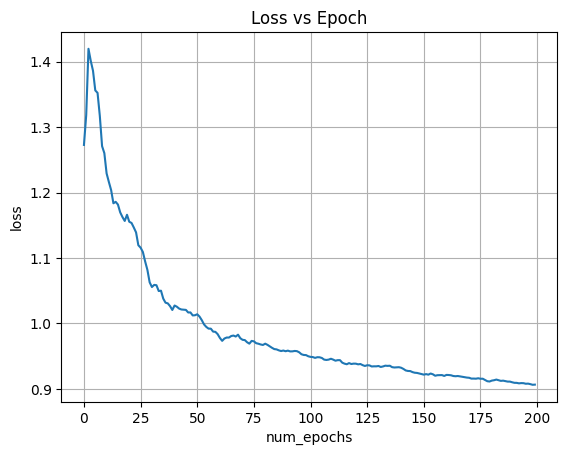

In [43]:
loss_sum=np.cumsum(losses)
x_axis=np.arange(len(losses))+1
avg_loss=loss_sum/x_axis
plt.plot(avg_loss)
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.grid()
print(losses[-1])

0.7400000095367432


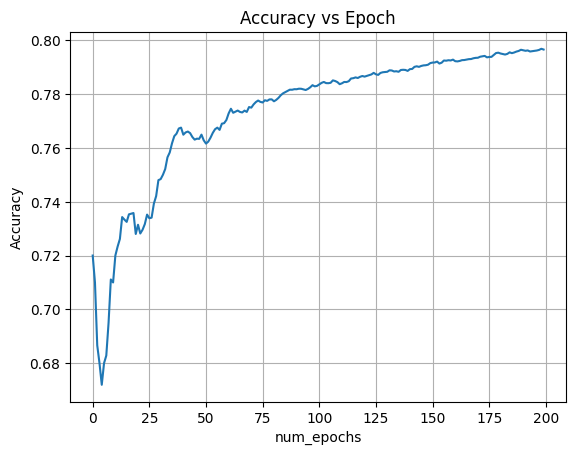

In [44]:
acc_sum=np.cumsum(accuracies)
x_axis=np.arange(len(acc_sum))+1
avg_acc=acc_sum/x_axis
plt.plot(avg_acc)
plt.xlabel('num_epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.grid()
print(accuracies[-1])

0.8125


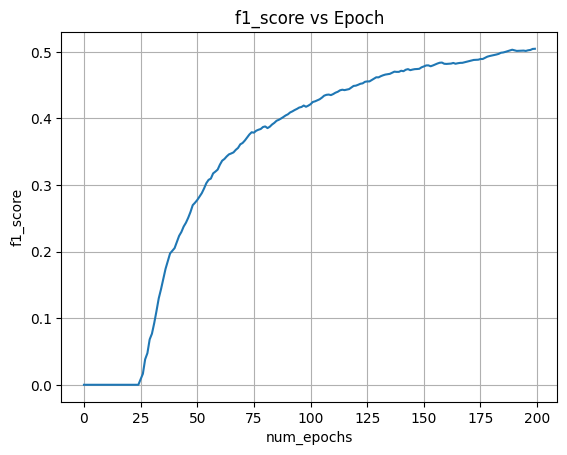

In [45]:
print(f1_score[-2])
f1_sum=np.cumsum(f1_score)
x_axis=np.arange(len(f1_score))+1
avg_f1=f1_sum/x_axis
plt.plot(avg_f1)
plt.xlabel('num_epochs')
plt.ylabel('f1_score')
plt.title('f1_score vs Epoch')
plt.grid()

0.5714285969734192


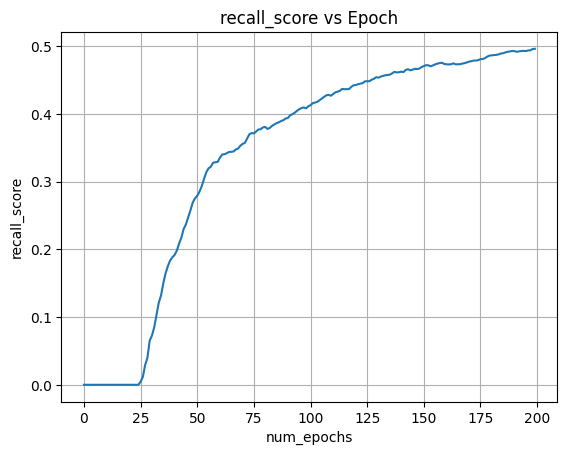

In [46]:
recall_sum=np.cumsum(recall)
x_axis=np.arange(len(recall))+1
avg_recall=recall_sum/x_axis
plt.plot(avg_recall)
plt.xlabel('num_epochs')
plt.ylabel('recall_score')
plt.title('recall_score vs Epoch')
plt.grid()
print(recall[-1])

0.6666666865348816


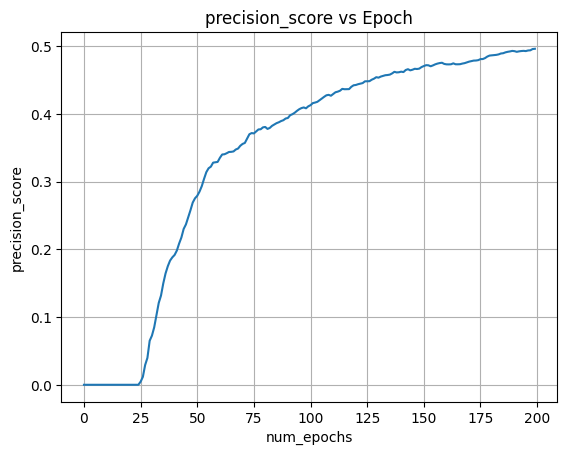

In [47]:
precision_sum=np.cumsum(recall)
x_axis=np.arange(len(precision_sum))+1
avg_precision=precision_sum/x_axis
plt.plot(avg_precision)
plt.xlabel('num_epochs')
plt.ylabel('precision_score')
plt.title('precision_score vs Epoch')
plt.grid()
print(precision[-3])

### DEMO

In [69]:
head_text1=data.iloc[1,2]
body_text1=data.iloc[1,9]

head_text2=data.iloc[9,2]
body_text2=data.iloc[9,9]
test_label=torch.zeros(2).to(device)
test_label[0],test_label[1]=label[1],label[9]
print(head_text2,body_text2)
# P,Lh,Lb=model2(head_vec[:10,...],body_vec[:10,...])


['Judge allows jury to consider manslaughter in Walter Scott trial'] Michael Slager is charged in the April 2015 shooting death of Walter Scott, who fled from a traffic stop and resisted arrest. The final moments of their encounter were captured on a bystander's cellphone video that shocked the nation.


In [57]:
head_vec1,body_vec1=tokenizer(head_text1, body_text1, word2vecLength, modelW2v.wv, norm_len)
head_vec2,body_vec2=tokenizer(head_text2, body_text2, word2vecLength, modelW2v.wv, norm_len)
print(head_vec1.shape,body_vec1.shape,head_vec2.shape,body_vec2.shape)

torch.Size([96, 100]) torch.Size([96, 100]) torch.Size([96, 100]) torch.Size([96, 100])


In [62]:
in_head=torch.zeros((2,head_vec1.shape[0],head_vec1.shape[1])).to(device)
in_head[0,...]=head_vec1
in_head[1,...]=head_vec2

in_body=torch.zeros((2,body_vec1.shape[0],body_vec1.shape[1])).to(device)
in_body[0,...]=body_vec1
in_body[1,...]=body_vec2
print(in_head.shape,in_body.shape)


torch.Size([2, 96, 100]) torch.Size([2, 96, 100])


In [63]:
test_out,Lh,Lb=model2(in_head,in_body)

In [70]:
print(torch.argmax(test_out,dim=1)==test_label)

tensor([True, True], device='cuda:0')
